# Détection de la Pêche Illégale: Exploration Scientifique

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [10, 6]

## 1. Le Problème et les Données

Pas de dataset de "peche illegale", il faut donc diviser le problème en deux :
- Détection de la pêche
- Détection de la pêche dans des zones interdites

**Question initiale** : Peut-on détecter l'activité de pêche à partir des mouvements des navires ?

**Hypothèse** : Les navires de pêche ont des patterns de mouvement différents des navires en transit.

In [4]:


# Chargement des données
print("Chargement des données AIS...")
df = pd.read_csv('../data/raw/drifting_longlines.csv')

print(f"Données : {len(df)} points AIS")
print(f"Navires uniques : {df['mmsi'].nunique()}")
print(f"Période : {pd.to_datetime(df['timestamp'], unit='s').min()} à {pd.to_datetime(df['timestamp'], unit='s').max()}")

# Première exploration
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.head()

Chargement des données AIS...
Données : 13968727 points AIS
Navires uniques : 110
Période : 2012-01-01 00:00:42 à 2016-11-24 23:59:59


,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,datetime
0,1.263956e+13,1.327137e+09,232994.281250,311748.65625,8.2,230.500000,14.865583,-26.853662,-1.0,dalhousie_longliner,2012-01-21 09:01:44
1,1.263956e+13,1.327137e+09,233994.265625,312410.34375,7.3,238.399994,14.863870,-26.856800,-1.0,dalhousie_longliner,2012-01-21 09:03:25
2,1.263956e+13,1.327137e+09,233994.265625,312410.34375,6.8,238.899994,14.861551,-26.860649,-1.0,dalhousie_longliner,2012-01-21 09:05:34
3,1.263956e+13,1.327143e+09,233994.265625,315417.37500,6.9,251.800003,14.822686,-26.865898,-1.0,dalhousie_longliner,2012-01-21 10:54:41
4,1.263956e+13,1.327143e+09,233996.390625,316172.56250,6.1,231.100006,14.821825,-26.867579,-1.0,dalhousie_longliner,2012-01-21 10:55:41


**Observation** : On a des données de position, vitesse, cap, et un label "is_fishing"

In [5]:
# Distribution des labels
print("\nDistribution des labels de pêche :")
print(df['is_fishing'].value_counts())

# Nettoyage : garder seulement les données labellisées
df_clean = df[df['is_fishing'] >= 0].copy()
df_clean['is_fishing_binary'] = (df_clean['is_fishing'] > 0).astype(int)

print(f"\nDonnées nettoyées : {len(df_clean)} points")
print(f"Pêche : {df_clean['is_fishing_binary'].mean()*100:.1f}%")



Distribution des labels de pêche :
is_fishing
-1.000000    13748986
 1.000000      138163
 0.000000       79574
 0.666667        1076
 0.333333         809
 0.750000         110
 0.250000           9
Name: count, dtype: int64

Données nettoyées : 219741 points
Pêche : 63.8%




## 2. Premier Modèle

**Question** : À quel point peut-on prédire l'activité de pêche ?


In [6]:

# Préparation des features de base
features = ['speed', 'course', 'distance_from_shore', 'distance_from_port', 
           'lat', 'lon']

X = df_clean[features].copy()
y = df_clean['is_fishing_binary']

# Gestion des valeurs manquantes
for col in X.columns:
    X[col] = X[col].fillna(X[col].median())

print("Features utilisées :", features)

# **Première tentative** : Division aléatoire
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_naive = RandomForestClassifier(n_estimators=100, random_state=42)
model_naive.fit(X_train, y_train)

accuracy_naive = model_naive.score(X_test, y_test)
print(f"Précision avec division aléatoire : {accuracy_naive:.1%}")


Features utilisées : ['speed', 'course', 'distance_from_shore', 'distance_from_port', 'lat', 'lon']
\Précision avec division aléatoire : 98.9%



**Résultat surprenant** : 99% de précision ! Trop beau pour être vrai...


## 3. Découverte du Data Leakage

**Question** : Pourquoi cette précision irréaliste ?

**Investigation** : Regardons d'où viennent les données de test...


In [10]:
# Vérification : même navire dans train et test ?
train_vessels = set(df_clean.loc[X_train.index, 'mmsi'])
test_vessels = set(df_clean.loc[X_test.index, 'mmsi'])
overlap = train_vessels.intersection(test_vessels)

print(f"Navires dans training : {len(train_vessels)}")
print(f"Navires dans test : {len(test_vessels)}")
print(f"Navires en commun : {len(overlap)}")
print(f"Pourcentage d'overlap : {len(overlap)/len(test_vessels)*1:.1%}")


Navires dans training : 110
Navires dans test : 110
Navires en commun : 110
Pourcentage d'overlap : 100.0%



**Problème identifié** : Les mêmes navires sont dans train ET test !
Le modèle apprend les patterns spécifiques de chaque navire.



## 4. Solution : Division par Navire

**Nouvelle approche** : Navires entiers dans train OU test, jamais les deux.


In [11]:

vessels = df_clean['mmsi'].unique()
train_vessels, test_vessels = train_test_split(vessels, test_size=0.2, random_state=42)

print(f"Navires pour training : {len(train_vessels)}")
print(f"Navires pour test : {len(test_vessels)}")

# Création des datasets
X_train_vessels = X[df_clean['mmsi'].isin(train_vessels)]
X_test_vessels = X[df_clean['mmsi'].isin(test_vessels)]
y_train_vessels = y[df_clean['mmsi'].isin(train_vessels)]
y_test_vessels = y[df_clean['mmsi'].isin(test_vessels)]

# Nouveau modèle
model_vessels = RandomForestClassifier(n_estimators=100, random_state=42)
model_vessels.fit(X_train_vessels, y_train_vessels)

accuracy_vessels = model_vessels.score(X_test_vessels, y_test_vessels)
print(f"\nPrécision avec division par navires : {accuracy_vessels:.1%}")


Navires pour training : 88
Navires pour test : 22

Précision avec division par navires : 73.3%



**Résultat réaliste** : 73%

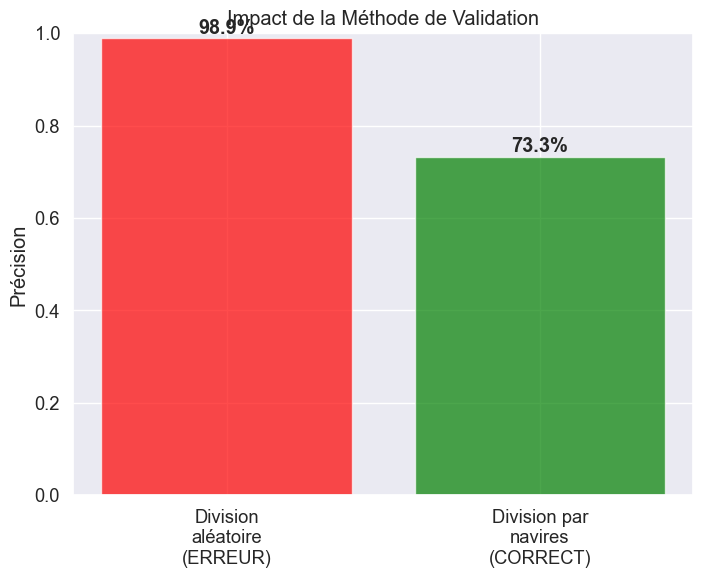

In [13]:

# Comparaison visuelle
accuracies = [accuracy_naive, accuracy_vessels]
methods = ['Division\naléatoire\n(ERREUR)', 'Division par\nnavires\n(CORRECT)']

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracies, color=['red', 'green'], alpha=0.7)
plt.ylabel('Précision')
plt.title('Impact de la Méthode de Validation')
plt.ylim(0.0, 1.0)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold')

plt.show()



**Leçon** : La méthodologie d'évaluation est cruciale

## 5. Ingénierie de Features

### Amélioration de la précision

**Question** : Quels comportements indiquent la pêche ?

**Hypothèses** :
- Les navires ralentissent pour pêcher
- Ils font plus de manœuvres
- Leurs trajectoires sont moins efficaces

In [14]:
# Chargement des features engineered
trip_features = pd.read_csv('engineered_trip_features.csv')
print(f"Features engineered : {len(trip_features)} voyages, {len(trip_features.columns)} features")

# Sélection des 15 features les plus importantes
selected_features = [
    'speed_min', 'course_changes_per_hour', 'speed_q25', 'speed_consistency',
    'speed_std', 'course_diff_std', 'area_covered', 'distance_from_port_q25',
    'distance_from_shore_q25', 'distance_from_shore_min', 'lon_range',
    'distance_from_port_min', 'course_diff_max', 'course_diff_mean', 'speed_mean'
]

# Préparation des données
X_features = trip_features[selected_features].copy()
y_features = trip_features['is_fishing']

# Gestion des valeurs manquantes
for col in X_features.columns:
    X_features[col] = X_features[col].fillna(X_features[col].median())

# Division par navires
vessels_features = trip_features['mmsi'].unique()
train_vessels_f, test_vessels_f = train_test_split(vessels_features, test_size=0.2, random_state=42)

X_train_f = X_features[trip_features['mmsi'].isin(train_vessels_f)]
X_test_f = X_features[trip_features['mmsi'].isin(test_vessels_f)]
y_train_f = y_features[trip_features['mmsi'].isin(train_vessels_f)]
y_test_f = y_features[trip_features['mmsi'].isin(test_vessels_f)]

# Entraînement du modèle final
final_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
final_model.fit(X_train_f, y_train_f)

accuracy_final = final_model.score(X_test_f, y_test_f)
print(f"\n Précision avec features engineered : {accuracy_final:.1%}")


Features engineered : 3591 voyages, 52 features

🎯 Précision avec features engineered : 85.8%



>**Amélioration significative** : 73% → 85% !


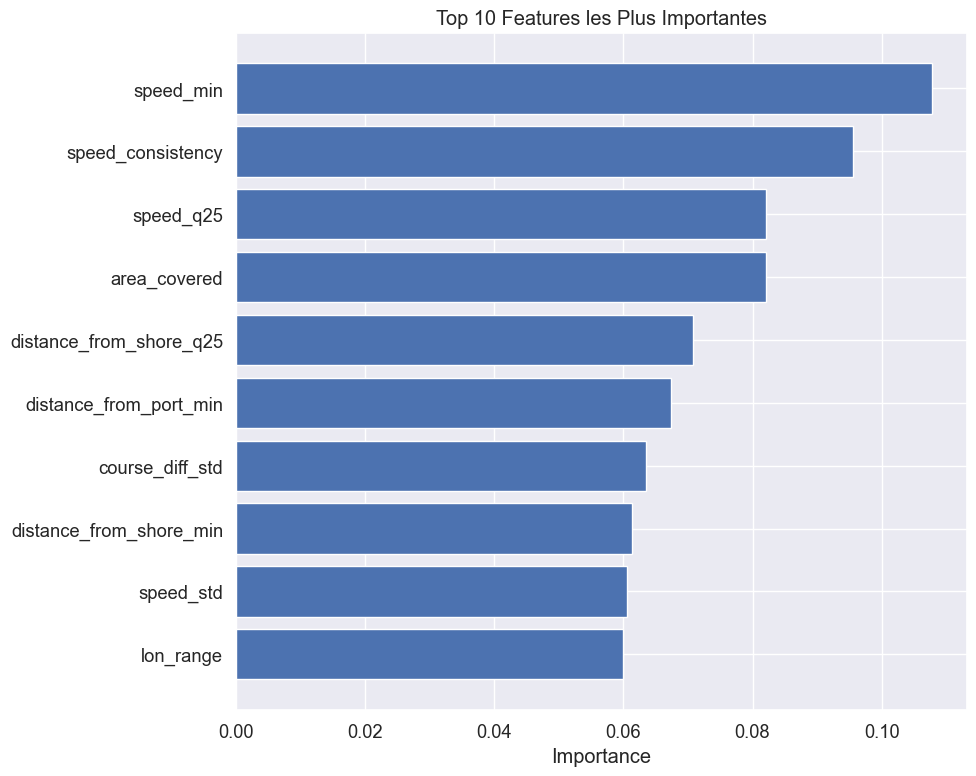


Top 3 features :
  speed_min: 0.108
  speed_consistency: 0.096
  speed_q25: 0.082


In [16]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualisation des top features
plt.figure(figsize=(10, 8))
top_10 = feature_importance.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Importance')
plt.title('Top 10 Features les Plus Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 3 features :")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")



**Interprétations** :
- `speed_min` : Les navires ralentissent pour pêcher
- `course_changes_per_hour` : Plus de manœuvres pendant la pêche
- `speed_q25` : Patterns de vitesse lente



## 6. Validation Croisée

**Question** : Notre modèle généralise-t-il vraiment ?

In [18]:

# Validation croisée avec groupes (navires)
gkf = GroupKFold(n_splits=5)
vessel_groups = trip_features['mmsi']

cv_scores = cross_val_score(
    final_model, X_features, y_features,
    groups=vessel_groups, cv=gkf, scoring='accuracy'
)

print(f"\n📊 Validation croisée (5-fold) :")
print(f"   Précision moyenne : {cv_scores.mean():.1%} ± {cv_scores.std():.1%}")
print(f"   Scores individuels : {[f'{s:.1%}' for s in cv_scores]}")



📊 Validation croisée (5-fold) :
   Précision moyenne : 87.8% ± 1.7%
   Scores individuels : ['88.3%', '88.0%', '89.7%', '88.3%', '84.7%']



**Résultat** : Performance consistante !


## 7. Apprentissage Non-Supervisé

**Question** : Les navires se regroupent-ils naturellement par comportement ?

**Hypothèse** : On trouvera des clusters distincts "pêche" vs "transit"


Clustering avec 47 features


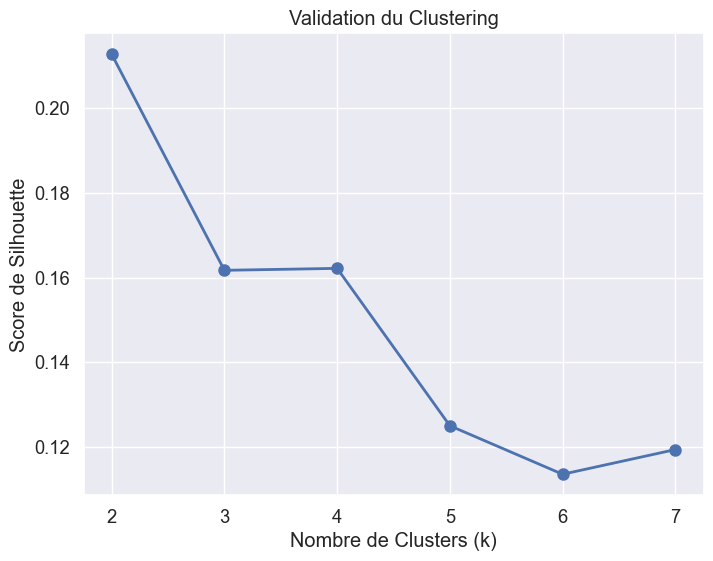


🔍 Clustering optimal : k = 2
   Score de silhouette : 0.213


In [20]:

# Préparation pour clustering
cluster_features = trip_features.drop(['trip_id', 'mmsi', 'start_time', 'end_time', 'is_fishing'], axis=1)

# Gestion des valeurs manquantes
for col in cluster_features.columns:
    cluster_features[col] = cluster_features[col].fillna(cluster_features[col].median())

# Standardisation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

print(f"Clustering avec {scaled_features.shape[1]} features")

# Test de différents nombres de clusters
k_range = range(2, 8)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(score)

# Graphique du score de silhouette
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Nombre de Clusters (k)')
plt.ylabel('Score de Silhouette')
plt.title('Validation du Clustering')
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\n🔍 Clustering optimal : k = {optimal_k}")
print(f"   Score de silhouette : {best_score:.3f}")



**Observation** : Score faible (0.21) → clustering faible



📈 Analyse des 2 clusters :
         fishing_proportion  is_fishing  speed_mean  duration_hours
cluster                                                            
0                     0.668       0.672       5.573          12.926
1                     0.743       0.746       6.589          11.250


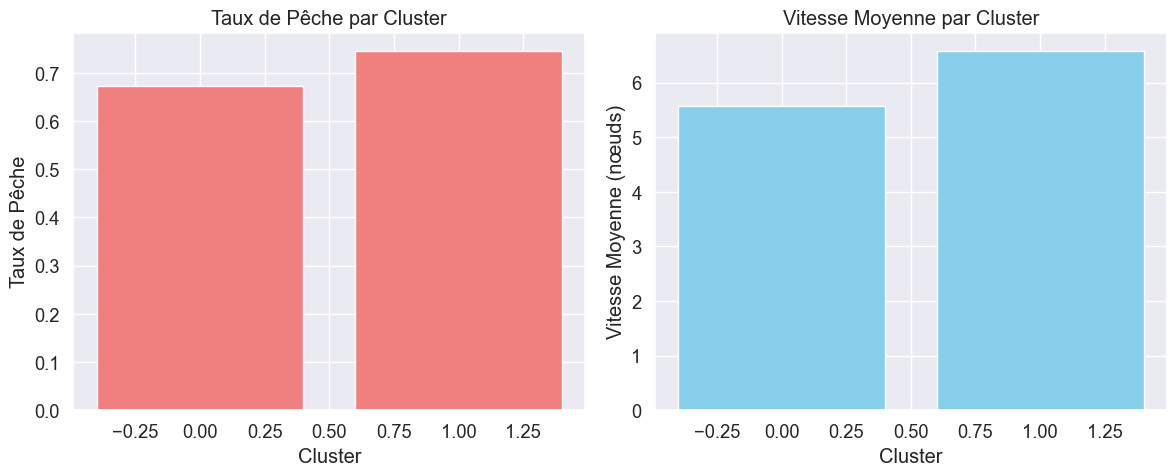

In [21]:

# Analyse des clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
trip_features['cluster'] = kmeans_final.fit_predict(scaled_features)

# Statistiques par cluster
cluster_stats = trip_features.groupby('cluster').agg({
    'fishing_proportion': 'mean',
    'is_fishing': 'mean',
    'speed_mean': 'mean',
    'duration_hours': 'mean'
}).round(3)

print(f"\n📈 Analyse des {optimal_k} clusters :")
print(cluster_stats)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Taux de pêche par cluster
axes[0].bar(range(optimal_k), cluster_stats['is_fishing'], color='lightcoral')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Taux de Pêche')
axes[0].set_title('Taux de Pêche par Cluster')

# Vitesse moyenne par cluster
axes[1].bar(range(optimal_k), cluster_stats['speed_mean'], color='skyblue')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Vitesse Moyenne (nœuds)')
axes[1].set_title('Vitesse Moyenne par Cluster')

plt.tight_layout()
plt.show()



**Résultat** : Pas de clusters distincts !
- Cluster 0 : 67% pêche
- Cluster 1 : 74% pêche

**Conclusion** : Les comportements sont sur un continuum, pas des catégories distinctes.

## 8. Comparaison des Approches


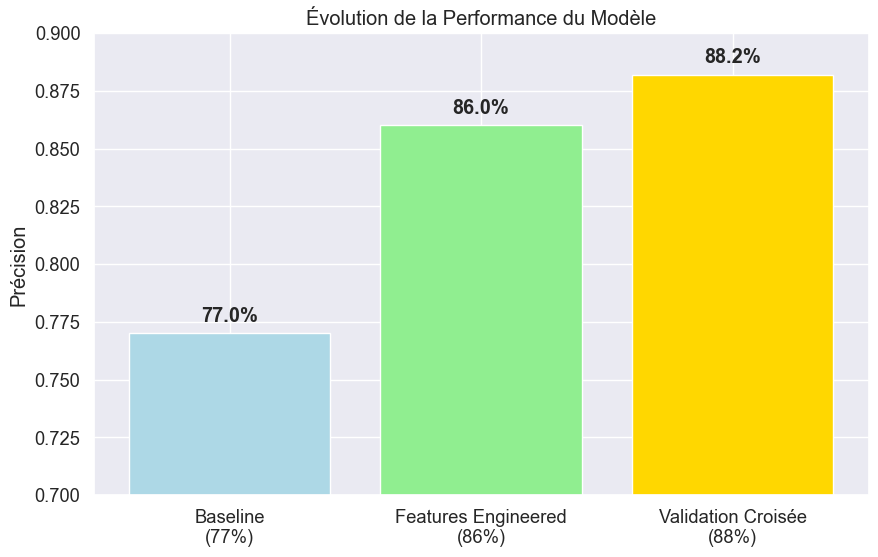

In [22]:

# Comparaison finale des méthodes
methods = ['Baseline\n(77%)', 'Features Engineered\n(86%)', 'Validation Croisée\n(88%)']
scores = [0.77, 0.86, 0.882]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, scores, color=['lightblue', 'lightgreen', 'gold'])
plt.ylabel('Précision')
plt.title('Évolution de la Performance du Modèle')
plt.ylim(0.7, 0.9)

for i, v in enumerate(scores):
    plt.text(i, v + 0.005, f'{v:.1%}', ha='center', fontweight='bold')

plt.show()